In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
from igraph import Graph, plot
import matplotlib.pyplot as plt
import skbio
import subprocess
import utils
import manta
from scipy.cluster.hierarchy import dendrogram
import itertools
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from collections import Counter
from venn import venn
import networkx as nx
from scipy.stats import spearmanr

%load_ext autoreload
%aimport utils
%aimport manta
%autoreload 1

# Read data and filter

In [2]:
TAX_LEVEL = 5
OUTDIR = 'data/both'

In [4]:
# Read data
df_raw_16s = pd.read_excel('data/16S_AV_OTU_table_wTaxa.xlsx')
meta_16s = pd.read_excel('data/16S_AV_March2019_Metadata.xlsx')
df_raw_18s = pd.read_excel('data/18S_AV_OTU_table_wTaxa.xlsx')
meta_18s = pd.read_excel('data/18S_AV_March2019_Metadata.xlsx')

In [5]:
df_raw_16s['OTU'] = df_raw_16s['OTU'] + '_16s'
df_raw_18s['OTU'] = df_raw_18s['OTU'] + '_18s'

In [6]:
df_raw_16s = df_raw_16s.set_index(['OTU', 'taxonomy'])
df_raw_18s = df_raw_18s.set_index(['OTU', 'taxonomy'])

In [7]:
df_filtered_16s = utils.filter_by_abundance(df_raw_16s, .01)
df_filtered_18s = utils.filter_by_abundance(df_raw_18s, .01)

In [8]:
df_filtered_16s = utils.filter_by_prevalence(df_filtered_16s, 3)
df_filtered_18s = utils.filter_by_prevalence(df_filtered_18s, 3)

In [9]:
df_filtered_16s = df_filtered_16s.reset_index().drop(columns='taxonomy').set_index('OTU')
df_filtered_18s = df_filtered_18s.reset_index().drop(columns='taxonomy').set_index('OTU')

In [10]:
df_filtered_relative_16s = df_filtered_16s / df_raw_16s.sum()
df_filtered_relative_18s = df_filtered_18s / df_raw_18s.sum()

In [11]:
df_filtered_relative_16s.columns = meta_16s.set_index('Sample_Names').loc[df_filtered_relative_16s.columns]['AV_Numbers'].tolist()

In [12]:
df_filtered_relative_18s.columns = meta_18s.set_index('Sample_Names').loc[df_filtered_relative_18s.columns]['AV_Numbers'].tolist()

In [13]:
columns = list(set(df_filtered_relative_16s.columns) & set(df_filtered_relative_18s.columns))
df_filtered_relative_16s = df_filtered_relative_16s[columns]
df_filtered_relative_18s = df_filtered_relative_18s[columns]

In [14]:
df_spearman = df_filtered_relative_16s.apply(lambda row1: df_filtered_relative_18s.apply(lambda row2: spearmanr(row1, row2), axis=1), axis=1)

In [15]:
pvals = df_spearman.applymap(lambda x: x[1]).values.flatten()

In [16]:
threshold = utils.correct_alpha(pvals)
threshold

0.003968956043480493

In [17]:
df_cor = df_spearman.applymap(lambda x: x[0] if x[1] <= threshold else 0.0)

# Build graph

(array([  20.,  108.,    0.,    0., 4169.,    0.,    0.,    0.,  163.,
          40.]),
 array([-0.8004513 , -0.63633781, -0.47222432, -0.30811083, -0.14399733,
         0.02011616,  0.18422965,  0.34834314,  0.51245663,  0.67657012,
         0.84068361]),
 <a list of 10 Patch objects>)

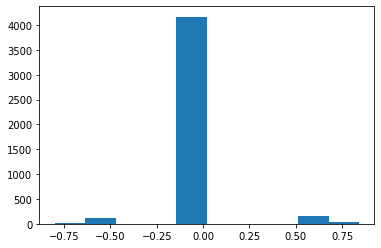

In [18]:
flatten_cor = utils.flatten_square_df(df_cor, k=1)
plt.hist(flatten_cor)

In [19]:
(df_cor != 0).sum().sum()

589

In [20]:
G = nx.Graph()
for _, row in df_cor.iterrows():
    a = row.name
    for b, cor in row.iteritems():
        if cor != 0:
            G.add_edge(a, b, weight=cor)

In [21]:
OTU_to_tax = {OTU:tuple(x.strip('_') for x in tax.split('; ')) for OTU, tax in df_raw_16s.index if OTU in G}
OTU_to_tax.update({OTU:tuple(x.strip('_') for x in tax.split('; ')) for OTU, tax in df_raw_18s.index if OTU in G})

In [22]:
for OTU, tax in OTU_to_tax.items():
    G = nx.relabel_nodes(G, {OTU:tax+(OTU,)})

In [23]:
for node, attrs in G.nodes.items():
    attrs['taxonomy'] = '; '.join(node[:min(len(node), TAX_LEVEL)])
    attrs['OTUs'] = 1

In [24]:
for node, attrs in G.nodes.items():
    G.nodes[node]['taxonomy']

In [25]:
G.nodes[('Bacteria', 'Bacteroidetes', 'Flavobacteriia', 'Flavobacteriales', 'NS9_marine_group', 'g', 'denovo1669_16s')]

{'taxonomy': 'Bacteria; Bacteroidetes; Flavobacteriia; Flavobacteriales; NS9_marine_group',
 'OTUs': 1}

In [26]:
print(len(G))
for level in range (8, 4, -1):
    member_to_supernode = utils.get_member_to_supernode(G, level)
    supernode_to_members = utils.get_supernode_to_members(member_to_supernode)
    togroup = utils.find_valid_grouping(G, supernode_to_members, level)
    for supernode in togroup:
        utils.merge_nodes(G, supernode_to_members[supernode], supernode)
    print(len(G))

152
123
114
92
77


In [27]:
for edge, attrs in G.edges.items():
    attrs['absweight'] = abs(attrs['weight'])
    attrs['color'] = 'green' if attrs['weight'] > 0 else 'red'

In [28]:
for n, attrs in G.nodes.items():
    if n[-1].startswith('denovo'):
        OTUs = [n[-1]]
    else:
        OTUs = [OTU for OTU, tax in OTU_to_tax.items() if len(tax) >= len(n) and tax[:len(n)] == n]
    try:
        attrs['abundance'] = df_filtered_relative_16s.loc[OTUs].mean().mean()
    except KeyError:
        attrs['abundance'] = df_filtered_relative_18s.loc[OTUs].mean().mean()

In [29]:
def domain(x):
    if type(x) == str:
        return '16s' if x.endswith('16s') else '18s'
    else:
        return '18s' if x[0] == 'Eukaryota' else '16s'

In [30]:
top10_connected_16s = [x for x, y in sorted([(i, j) for i, j in G.degree if domain(i) == '16s'], key=lambda x: x[1], reverse=True)[:10]]
top10_connected_18s = [x for x, y in sorted([(i, j) for i, j in G.degree if domain(i) == '18s'], key=lambda x: x[1], reverse=True)[:10]]

top10_abundance_16s = sorted([x for x in G.nodes if domain(x) == '16s'], key=lambda n: G.nodes[n]['abundance'], reverse=True)[:10]
top10_abundance_18s = sorted([x for x in G.nodes if domain(x) == '18s'], key=lambda n: G.nodes[n]['abundance'], reverse=True)[:10]


for n, attrs in G.nodes.items():
    attrs['domain'] = domain(n)
    if n in top10_connected_16s and n in top10_abundance_16s:
        attrs['color'] = 'orange'
    elif n in top10_connected_16s:
        attrs['color'] = 'red'
    elif n in top10_abundance_16s:
        attrs['color'] = 'yellow'
    elif n in top10_connected_18s and n in top10_abundance_18s:
        attrs['color'] = 'violet'
    elif n in top10_connected_18s:
        attrs['color'] = 'blue'
    elif n in top10_abundance_18s:
        attrs['color'] = 'green'
    else:
        if domain(n) == '16s':
            attrs['color'] = 'pink'
        else:
            attrs['color'] = 'indigo'

In [31]:
nx.write_gml(G, os.path.join(OUTDIR, 'graph.gml'), stringizer=lambda x: '; '.join(x) if type(x)!=str else x)

In [32]:
G = nx.read_gml(os.path.join(OUTDIR, 'graph.gml'))
Counter([G.edges[n]['color'] for n in G.edges])

Counter({'red': 120, 'green': 132})

In [33]:
len(G.nodes)

77